In [35]:
%matplotlib inline 

In [36]:
# set a batch size to work with
batch_size = 4

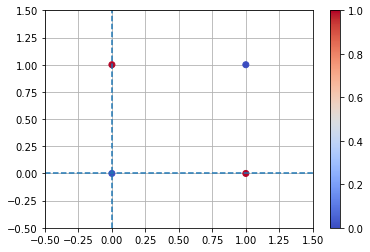

In [37]:
# visualize task
import matplotlib.pyplot as plt
plt.rc('axes', axisbelow=True)

xs   = [0, 1, 0, 1]
ys   = [0, 0, 1, 1]
xor  = [0, 1, 1, 0]

plt.scatter(xs, ys, c=xor, cmap='coolwarm')
plt.colorbar()

plt.xlim(-0.5, 1.5) 
plt.ylim(-0.5, 1.5)

plt.grid(True)

plt.axhline(0, linestyle='dashed')
plt.axvline(0, linestyle='dashed')

In [33]:
!pip install tensorboard

In [38]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [39]:
import numpy as np
from tensorboardX import SummaryWriter
from datetime import datetime
logdir = "logs"

In [40]:
def activation(x):
    return 1.0 / (1.0 + np.exp(-x))
def dactivation(x):
    return np.exp(-x) / (1 + np.exp(-x))**2

In [70]:
# MultiLayer Perceptron class
# modified to take in batches (multiple inputs in matrix form)
# instead of one input in vector form
class MLP:
    def __init__(self, *args):
        np.random.seed(123)
        self.shape = args
        n = len(args)
        self.layers = []
        self.layers.append(np.ones(((batch_size,
                                     self.shape[0]+1)))) # input layer
            # expanded to work with an entire batch instead of just one input
        for i in range(1,n):   # hidden layers, also expanded
            self.layers.append(np.ones((batch_size,
                                        self.shape[i]))) 
        self.weights = [] # weights for all layers
        self.weights.append(np.zeros((self.shape[0]+1,
                                      self.shape[1])))   
        for i in range(1, n-1):
            self.weights.append(np.zeros((self.shape[i],
                                         self.shape[i+1])))
        self.reset()
        
        # for debugging:
        print("shape:")
        print(self.shape)
        print("layers:")
        for i in range(n):
            print(self.layers[i].shape)
        print("weights:")
        for i in range(n-1):
            print(self.weights[i].shape)
    
    def reset(self):
        Z = np.random.random((self.shape[0]+1,
                              self.shape[1]))
        self.weights[0][...] = (2*Z-1)*1
        for i in range(1, len(self.weights)):
            Z = np.random.random((self.shape[i],
                                  self.shape[i+1]))
            self.weights[i][...] = (2*Z-1)*1

    def propagate_forward(self, data):
        self.layers[0:-1][0] = data # set input
        for i in range(1,len(self.shape)):
            s_i = self.layers[i-1] @ self.weights[i-1]
               # changed scalar multiplication to matrox multiplication
            self.layers[i][...] = activation(s_i)
        return self.layers[-1]

    def propagate_backward(self, target, lrate=0.1):
        deltas = []
        derror = -(target-self.layers[-1]) # y-y^
        s_last = self.layers[-2] @ self.weights[-1]
        delta_last = derror @ dactivation(s_last)
        deltas.append(delta_last)
        for i in range(len(self.shape)-2,0,-1):
            s_i = self.layers[i-1] @ self.weights[i-1]
            delta_i = deltas[0] @ self.weights[i].T * dactivation(s_i)
            deltas.insert(0,delta_i)            
        for i in range(len(self.weights)):
            layer = np.atleast_2d(self.layers[i])
            delta = np.atleast_2d(deltas[i])
            dw = -lrate * layer.T @ delta
            self.weights[i] += dw 

        error = (target-self.layers[-1])**2 
        return error.sum()

In [76]:
from sklearn import preprocessing
def learn(network, X, Y, valid_split, test_split, writer, epochs=20, lrate=0.1):
    # Prepocessing
        nb_samples = len(Y)
        X_train = X[0:int(nb_samples*(1-valid_split-test_split))]
        Y_train = Y[0:int(nb_samples*(1-valid_split-test_split))]
        X_valid = X[int(nb_samples*(1-valid_split-test_split)):int(nb_samples*(1-test_split))]
        Y_valid = Y[int(nb_samples*(1-valid_split-test_split)):int(nb_samples*(1-test_split))]
        X_test  = X[int(nb_samples*(1-test_split)):]
        Y_test  = Y[int(nb_samples*(1-test_split)):]
    
        scaler = preprocessing.StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_valid = scaler.transform(X_valid)
        X_test  = scaler.transform(X_test)
        
    # Train (Mini-batch Gradient Descent)   
        # number of batches
        batch_num = int(len(Y_train)/batch_size)
        print("number of batches/epoch: " + str(batch_num))
        
        for i in range(epochs):
            # mixing data before every new epoch
            randperm = np.random.permutation(len(X_train))
            X_train, Y_train = X_train[randperm], Y_train[randperm]
            
            train_err = 0
            for k in range(batch_num): # modified to train with an entire batch
                batch_start = k*batch_size
                batch_end = batch_start+batch_size
                network.propagate_forward( X_train[batch_start:batch_end] )
                train_err += network.propagate_backward( Y_train[batch_start:batch_end], lrate )
            train_err /= batch_num*batch_size

    # Validation
            valid_err = 0
            o_valid = np.zeros(Y_valid.shape) 
            batch_num = int(len(Y_valid)/batch_size)
            for k in range(batch_num): # modified to validate with an entire batc
                batch_start = k*batch_size
                batch_end = batch_start+batch_size
                o_valid[batch_start:batch_end] = network.propagate_forward(X_valid[batch_start:batch_end]).T
                valid_err += np.linalg.norm(o_valid[batch_start:batch_end]-Y_valid[batch_start:batch_end])
            valid_err /= batch_num*batch_size
            
            
            writer.add_scalar('train', scalar_value=train_err, global_step=i)
            writer.add_scalar('validation', scalar_value=valid_err, global_step=i)
            print("%d epoch, train_err: %.4f, valid_err: %.4f" % (i, train_err, valid_err))

    # Testing
        print("\n--- TESTING ---\n")
        test_err = 0
        o_test = np.zeros(Y_test.shape)
        batch_num = int(len(Y_test)/batch_size)
        for k in range(batch_num): # modified to test with an entire batch
            batch_start = k*batch_size
            batch_end = batch_start+batch_size
            o_test[batch_start:batch_end] = network.propagate_forward(X_test[batch_start:batch_end]).T
            test_err += np.linalg.norm(o_test[batch_start:batch_end]-Y_test[batch_start:batch_end])
            print(k, X_test[k], '%.2f' % o_test[k], ' (elvart eredmeny: %.2f)' % Y_test[k])
        test_err /= batch_num*batch_size

        plt.scatter(X_test[:,0], X_test[:,1], c=np.round(o_test[:]), cmap=plt.cm.coolwarm)

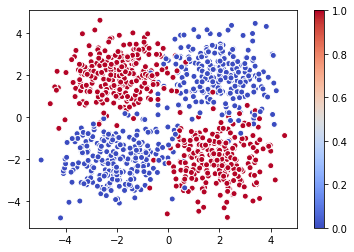

In [72]:
# Generating data:
nb_samples=1024
X = np.zeros((nb_samples,2))
Y = np.zeros(nb_samples)
for i in range(0,nb_samples,4):
    noise = np.random.normal(0,1,8)
    X[i], Y[i] = (-2+noise[0],-2+noise[1]), 0
    X[i+1], Y[i+1] = (2+noise[2],-2+noise[3]), 1
    X[i+2], Y[i+2] = (-2+noise[4],2+noise[5]), 1
    X[i+3], Y[i+3] = (2+noise[6],2+noise[7]), 0

plt.scatter(X[:,0],X[:,1],c=Y[:], cmap=plt.cm.coolwarm, linewidth=1, edgecolors='w')
plt.colorbar();

In [73]:
network = MLP(2,100,10,1)

shape:
(2, 100, 10, 1)
layers:
(4, 3)
(4, 100)
(4, 10)
(4, 1)
weights:
(3, 100)
(100, 10)
(10, 1)


In [74]:
now = datetime.now()
date_time = now.strftime("%Y%m%d_%H-%M-%S")
writer = SummaryWriter(logdir+"/"+date_time, flush_secs=1)

number of batches/epoch: 160
0 epoch, train_err: 1.0035, valid_err: 0.2500
1 epoch, train_err: 1.0001, valid_err: 0.2500
2 epoch, train_err: 1.0001, valid_err: 0.2500
3 epoch, train_err: 1.0001, valid_err: 0.2500
4 epoch, train_err: 1.0001, valid_err: 0.2500
5 epoch, train_err: 1.0001, valid_err: 0.2500
6 epoch, train_err: 1.0000, valid_err: 0.2500
7 epoch, train_err: 1.0001, valid_err: 0.2500
8 epoch, train_err: 1.0000, valid_err: 0.2500
9 epoch, train_err: 1.0000, valid_err: 0.2500
10 epoch, train_err: 1.0000, valid_err: 0.2500
11 epoch, train_err: 1.0000, valid_err: 0.2500
12 epoch, train_err: 1.0000, valid_err: 0.2500
13 epoch, train_err: 1.0000, valid_err: 0.2500
14 epoch, train_err: 1.0000, valid_err: 0.2500
15 epoch, train_err: 1.0001, valid_err: 0.2500
16 epoch, train_err: 1.0000, valid_err: 0.2500
17 epoch, train_err: 1.0000, valid_err: 0.2500
18 epoch, train_err: 1.0000, valid_err: 0.2500
19 epoch, train_err: 1.0000, valid_err: 0.2500
20 epoch, train_err: 0.9999, valid_err: 0

179 epoch, train_err: 1.0000, valid_err: 0.2500
180 epoch, train_err: 1.0000, valid_err: 0.2500
181 epoch, train_err: 1.0000, valid_err: 0.2500
182 epoch, train_err: 1.0000, valid_err: 0.2500
183 epoch, train_err: 1.0000, valid_err: 0.2500
184 epoch, train_err: 1.0000, valid_err: 0.2500
185 epoch, train_err: 1.0000, valid_err: 0.2500
186 epoch, train_err: 1.0000, valid_err: 0.2500
187 epoch, train_err: 1.0000, valid_err: 0.2500
188 epoch, train_err: 1.0000, valid_err: 0.2500
189 epoch, train_err: 1.0000, valid_err: 0.2500
190 epoch, train_err: 1.0000, valid_err: 0.2500
191 epoch, train_err: 1.0000, valid_err: 0.2500
192 epoch, train_err: 1.0000, valid_err: 0.2500
193 epoch, train_err: 1.0000, valid_err: 0.2500
194 epoch, train_err: 1.0000, valid_err: 0.2500
195 epoch, train_err: 1.0000, valid_err: 0.2500
196 epoch, train_err: 1.0000, valid_err: 0.2500
197 epoch, train_err: 1.0000, valid_err: 0.2500
198 epoch, train_err: 1.0000, valid_err: 0.2500
199 epoch, train_err: 1.0000, valid_err:

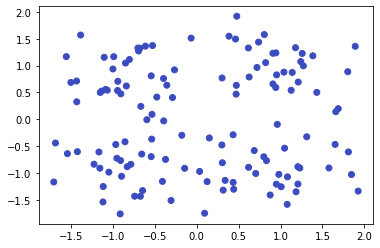

In [75]:
network.reset()
# we have 1024 data and 32 batch with a size of 32 element/batch
valid_split = 0.25   # 8 batch
test_split = 0.125   # 4 batch

learn(network, X, Y, valid_split, test_split, writer, epochs=200, lrate=1.5)

In [47]:
%tensorboard --logdir logs --port 6007

Reusing TensorBoard on port 6007 (pid 16188), started 5 days, 23:11:49 ago. (Use '!kill 16188' to kill it.)